<a href="https://colab.research.google.com/github/Sean-Wu-TW/257-Group-Project/blob/main/Resnet34_facemask_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/CMPE257projectdata"

/content/drive/MyDrive/CMPE257projectdata


In [3]:
ls

maskdata/  masks2.0/  savedmodel


In [4]:
import os
import pandas as pd
import numpy as np
from fastai.callbacks.hooks import *

import cv2
import torch

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [6]:
from fastai import *
from fastai.vision import *

#### check if CUDA is avaialble

In [7]:
torch.__version__

'1.7.0+cu101'

In [8]:
torch.version.cuda

'10.1'

In [9]:
#if using google colab: set runtime to GPU
torch.cuda.is_available()

True

In [10]:
!nvidia-smi

Mon Nov 23 20:20:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Load the data as an Image data bunch

In [11]:
path = Path('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata')
path.ls()

[PosixPath('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/train'),
 PosixPath('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/test')]

In [12]:
CONST_IMG_DIMENSION =224 #=224 = 32 * 7 

#try without resize squish?
data = (ImageList.from_folder(path)
       .split_by_folder(train='train',valid='test')
       .label_from_folder()
       .transform(get_transforms(),size=CONST_IMG_DIMENSION,resize_method=ResizeMethod.SQUISH)
       .databunch(bs=10))
data

ImageDataBunch;

Train: LabelList (616 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
without_mask,without_mask,without_mask,without_mask,without_mask
Path: /content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata;

Valid: LabelList (198 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
with_mask,with_mask,with_mask,with_mask,with_mask
Path: /content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata;

Test: None

In [13]:
#check classes
data.classes

['with_mask', 'without_mask']

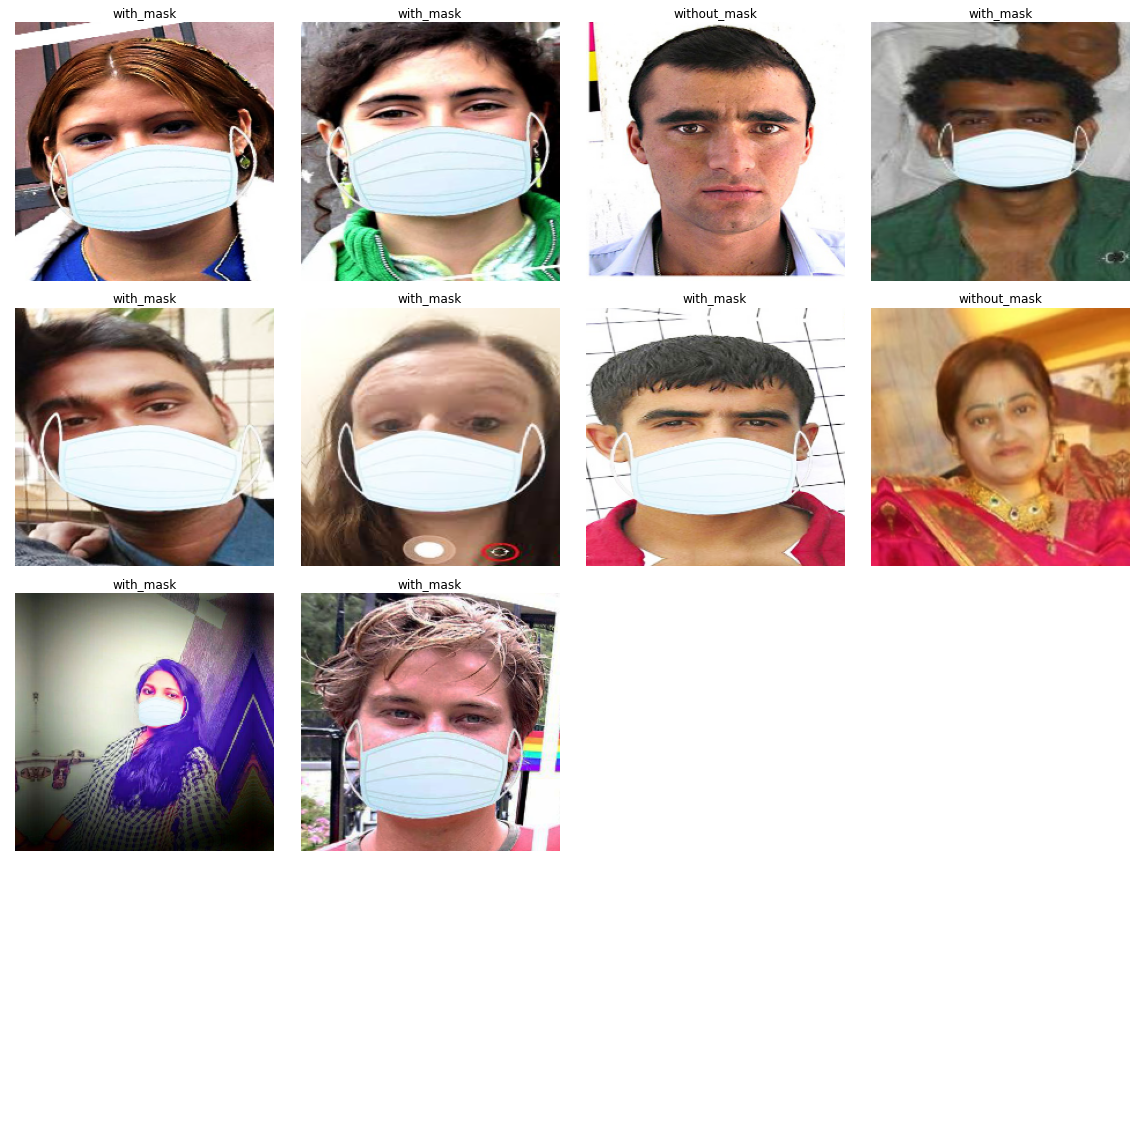

In [14]:
data.show_batch()

#### Train using Resnet 34

In [15]:
learn = cnn_learner(data,models.resnet34,metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [16]:
learn.fit_one_cycle(4)

In [17]:
model=learn.model.eval()
#model

In [18]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

Classification: with_mask


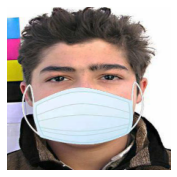

In [19]:
#verify training data

picnum=300
img, classification = data.train_ds[picnum]
img.show()
print('Classification:', classification)
#data.valid_ds.y[picnum]

#### plot important features in an image according to activations and gradients

In [20]:
#find hooks with backpropagation
#more on hooks: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html

def find_backward_hooks(img_tensor, classification, model):
    with hook_output(model[0]) as hook_acts: #returns activations
        with hook_output(model[0], grad=True) as hook_grads: #returns gradients
            preds = model(img_tensor)
            preds[0,int(classification)].backward()
    return hook_acts,hook_grads

In [21]:
#plot a heatmap of features
def plot_heatmap(tensor_inp, image, title):
    _,ax = plt.subplots()
    image.show(ax)
    ax.imshow(tensor_inp, alpha=0.6, extent=(0,CONST_IMG_DIMENSION,CONST_IMG_DIMENSION,0),
              interpolation='bilinear', cmap='seismic');
    plt.title(title)

In [22]:
#find important features and overlay them on the image
def find_feature_importance(img, classification):
  

  img_tensor,_ = data.one_item(img)
  image = Image(img_tensor.view(3,CONST_IMG_DIMENSION,CONST_IMG_DIMENSION))

  img_tensor = img_tensor.cuda() # .cuda() transfers a tensor from CPU to GPU 

  hook_acts,hook_grads = find_backward_hooks(img_tensor, classification, model)

  acts  = hook_acts.stored[0].cpu() # .cpu() transfers a tensor from GPU to CPU 
  acts_avg = acts.mean(0) #find the mean of activations per each lcoation

  grads = hook_grads.stored[0].cpu()
  grads = grads[0]
  grads_avg = grads.mean(0)

  plot_heatmap(acts_avg, image,'heatmap of activations')

  plot_heatmap(grads_avg, image, 'heatmap of gradients')


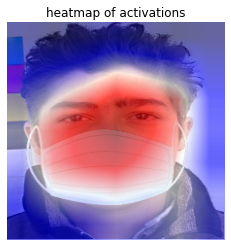

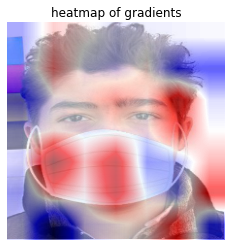

In [23]:
find_feature_importance(img, classification)

In [24]:
# m=learn.model.eval()

# idx=301
# x,y = data.train_ds[idx]
# x.show()
# #data.valid_ds.y[idx]

# xb,_ = data.one_item(x)
# xb_im = Image(xb.view(3,224,224))
# xb = xb.cuda()

# xb_im.shape

# def hooked_backward(cat=y):
#     with hook_output(m[0]) as hook_a: 
#         with hook_output(m[0], grad=True) as hook_g:
#             preds = m(xb)
#             preds[0,int(cat)].backward()
#     return hook_a,hook_g

# hook_a,hook_g = hooked_backward()

# acts  = hook_a.stored[0].cpu()
# acts.shape

# avg_acts = acts.mean(0)
# avg_acts.shape

# def show_heatmap(hm):
#     _,ax = plt.subplots()
#     xb_im.show(ax)
#     ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
#               interpolation='bilinear', cmap='magma');

# show_heatmap(avg_acts)

#### classification statistics

In [25]:
def show_stats_classif(leaner):
  classif_int = ClassificationInterpretation.from_learner(learn)
  classif_int.plot_confusion_matrix()

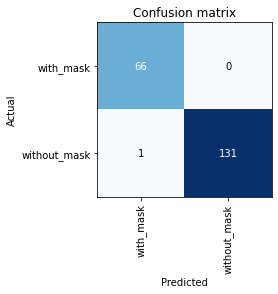

In [26]:
show_stats_classif(learn)

#### Classify unseen input

In [27]:
learn.model_dir ='/content/drive/MyDrive/CMPE257projectdata/model' #save model parameters to this dir

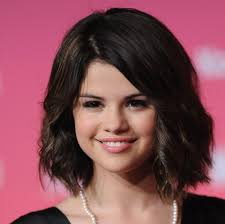

In [28]:
#check an image without mask
challenge_img = open_image('/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/test/0/11.jpg')
challenge_img

In [29]:
classification, *_= learn.predict(challenge_img)
print(classification)

without_mask


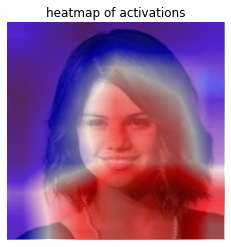

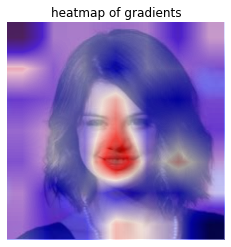

In [30]:
find_feature_importance(challenge_img, classification)

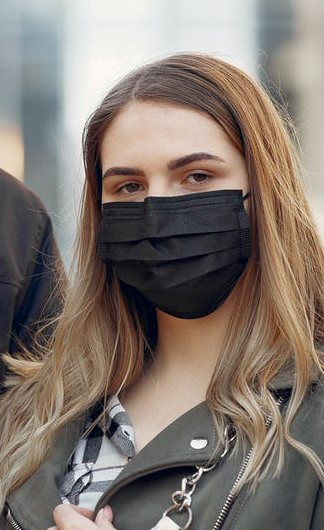

In [31]:
#check an image with mask
challenge_img = open_image('/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/test/1/7 w.jpeg')
challenge_img

In [32]:
classification, *_= learn.predict(challenge_img)
print(classification)

with_mask


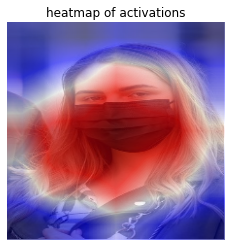

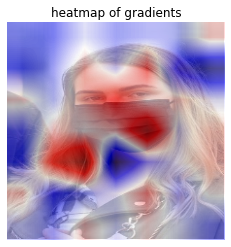

In [33]:
find_feature_importance(challenge_img, classification)

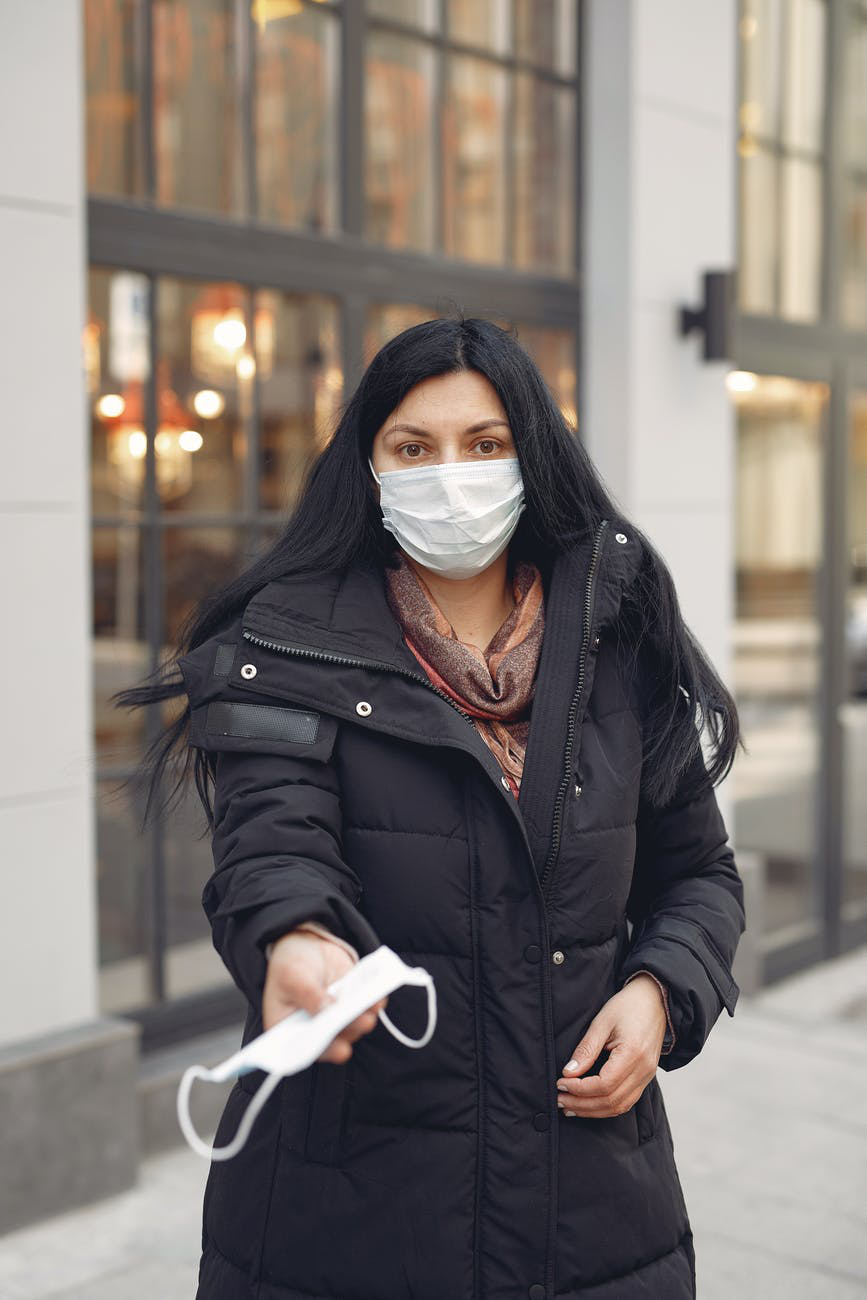

In [34]:
challenge_img = open_image('/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/test/1/10.jpeg')
challenge_img

In [35]:
classification, *_= learn.predict(challenge_img)
print(classification)

with_mask


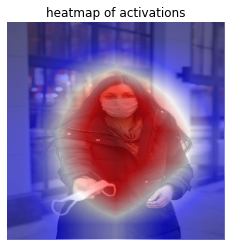

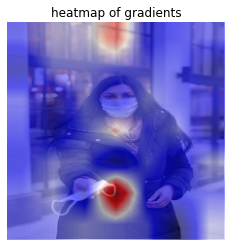

In [36]:
find_feature_importance(challenge_img, classification)

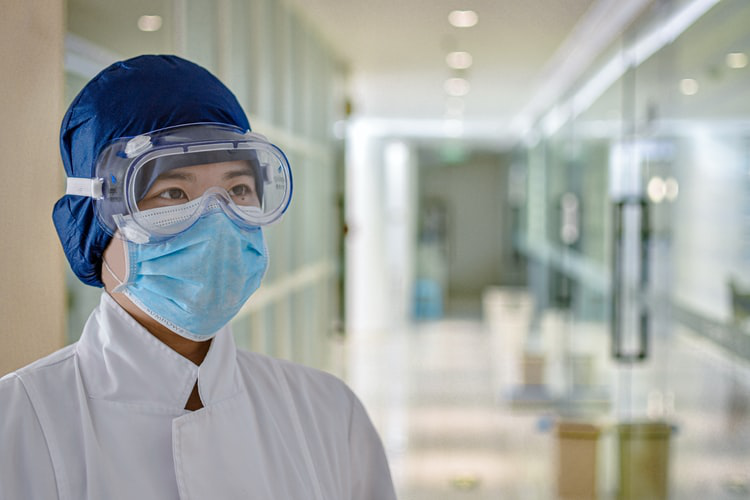

In [37]:
challenge_img = open_image('/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/train/1/16.jpg')
challenge_img

In [38]:
classification, *_= learn.predict(challenge_img)
print(classification)

with_mask


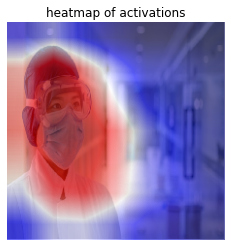

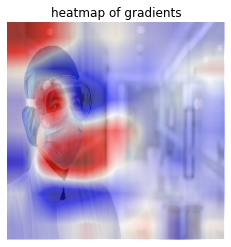

In [39]:
find_feature_importance(challenge_img, classification)

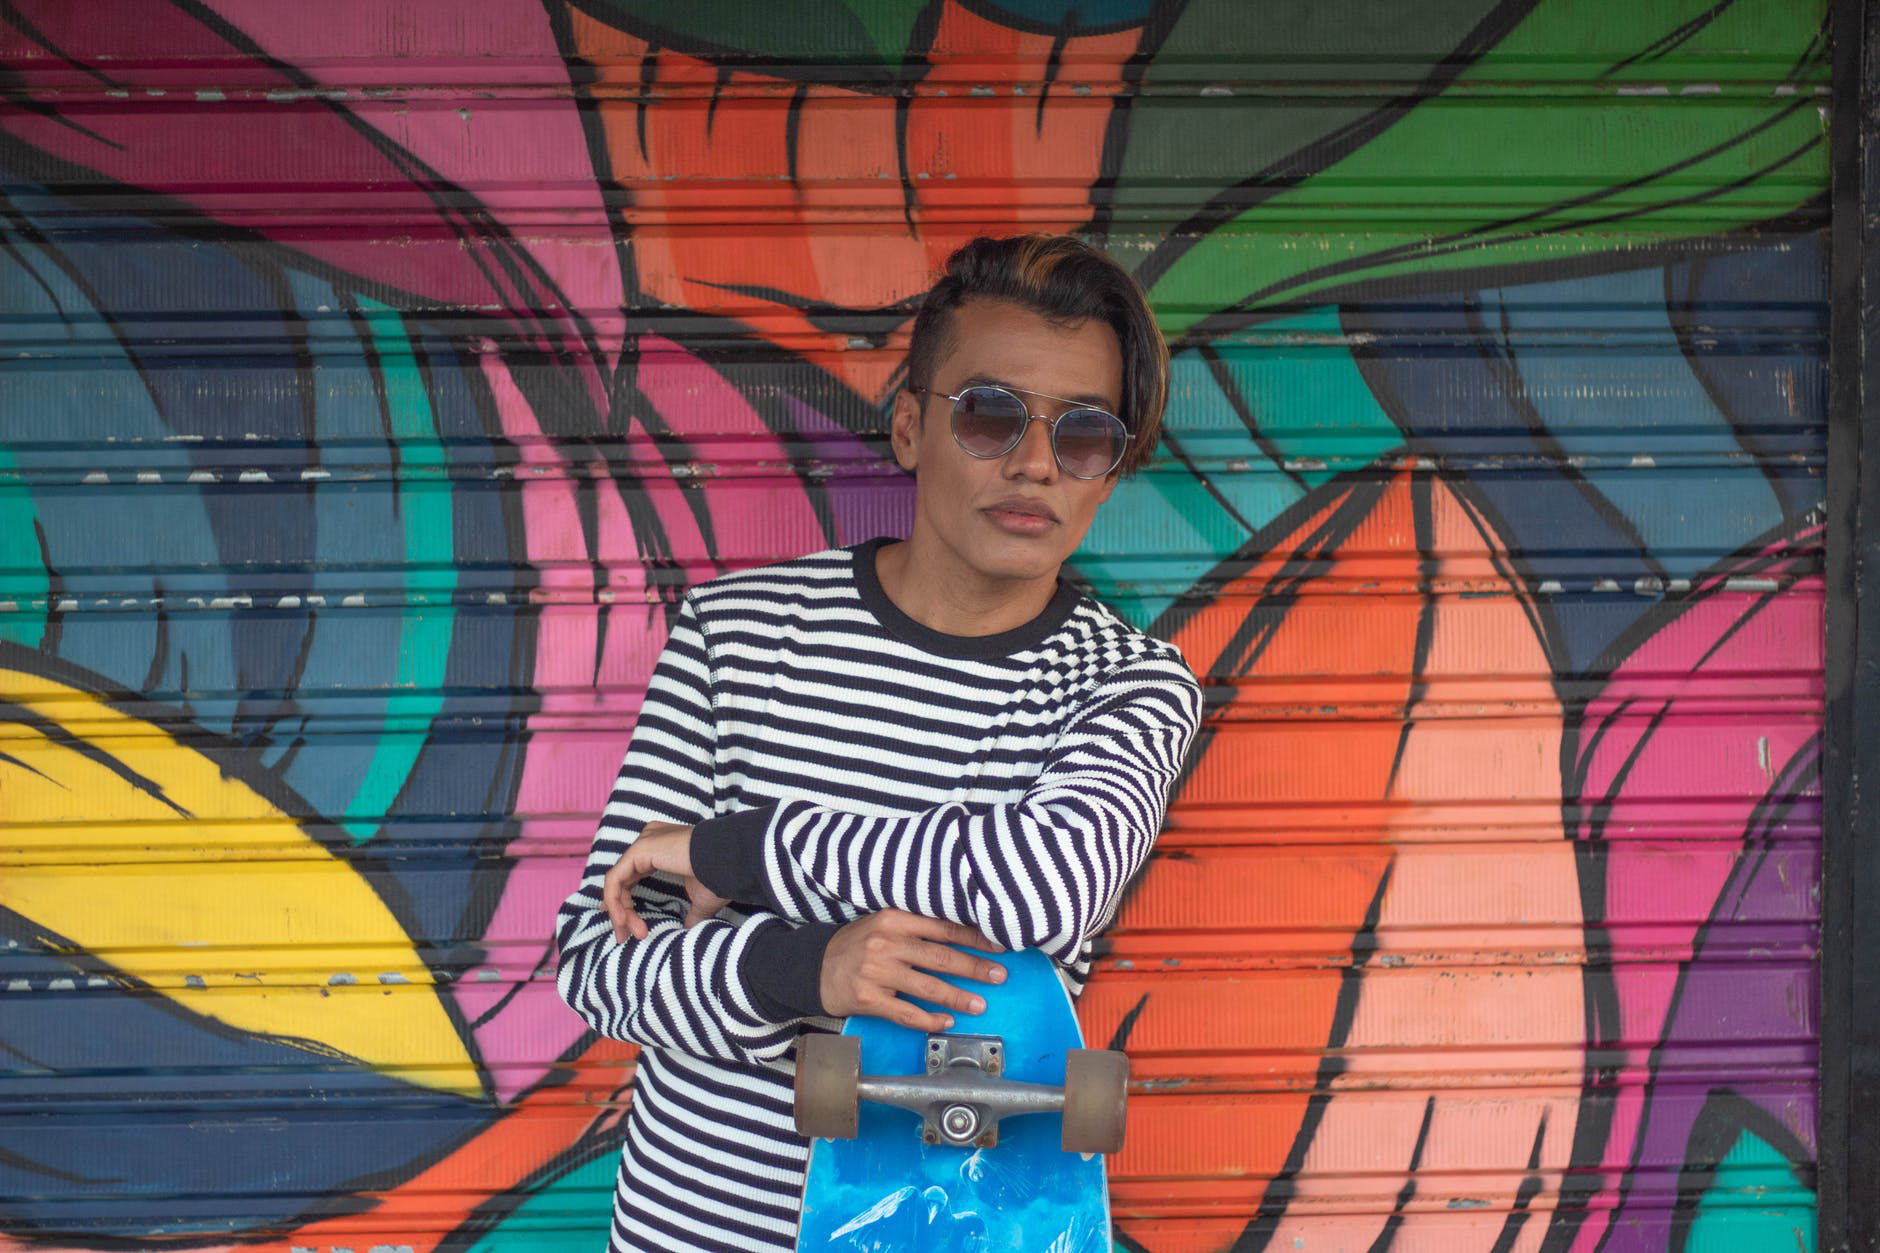

In [42]:
challenge_img = open_image('/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/train/0/pexels-photo-4048805.jpeg')
challenge_img

In [43]:
classification, *_= learn.predict(challenge_img)
print(classification)

without_mask


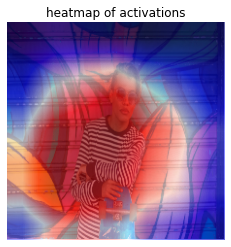

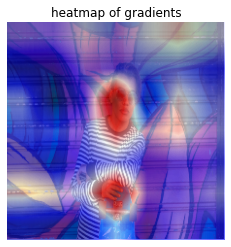

In [44]:
find_feature_importance(challenge_img, classification)

In [40]:
learn.export(Path('/content/drive/MyDrive/CMPE257projectdata/savedmodel'))

In [ ]:
import cv2
import torch

In [45]:
color_dict ={0:(0,255,0),1:(255,0,0)}
labels_dict=['With Mask','Without Mask']
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
source=cv2.VideoCapture(0)
# learn =load_learner('','export.pkl')
while True:
    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:

        face_img=gray[y:y+w,x:x+w]
        # resized=cv2.resize(face_img,(100,100))
        # normalized=resized/255.0
        # reshaped=np.reshape(normalized,(1,100,100,1))
        # result=model.predict(reshaped)
        img_t = pil2tensor(face_img, np.float32)
        image = Image(img_t)
        label = learn.predict(image)[0]
        # label=np.argmax(result,axis=1)[0]

        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)


    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)

    if(key=='q'):
        break

cv2.destroyAllWindows()
source.release()

error: ignored